ViT

In [ ]:
#FashionMNIST 다운로드
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets

def subset_sampler(dataset, classes, max_len):
    target_idx=defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices=list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)

train_dataset=datasets.FashionMNIST(root="../datasets", download=True, train=True) #root: 데이터세트가 저장될 디렉터리 위치
test_dataset=datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes=train_dataset.classes #데이터세트에 포함된 속성
class_to_idx=train_dataset.class_to_idx

print(classes)
print(class_to_idx)

subset_train_dataset=subset_sampler( #서브 샘플링 수행
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset=subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

print(f"Training Data Size: {len(subset_train_dataset)}")
print(f"Testing Data Size: {len(subset_test_dataset)}")
print(train_dataset[0])

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.3MB/s]

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Training Data Size: 10000
Testing Data Size: 1000
(<PIL.Image.Image image mode=L size=28x28 at 0x7A6B8E7BEAD0>, 9)



/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
#이미지 전처리
import torch
from torchvision import transforms
from transformers import AutoImageProcessor

image_processor=AutoImageProcessor.from_pretrained( #사전 학습된 ViT 모델을 활용해 전처리 진행
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize( #학습에 사용하려는 이미지를 ViT 모델과 맞추기 위해 크기 조정
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda( #단일 채널을 복제해 다중 채널 이미지로 변환
            lambda x: torch.cat([x,x,x], 0)
        ),
        transforms.Normalize( #정규화
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

print(f"size: {image_processor.size}")
print(f"mean: {image_processor.image_mean}")
print(f"std: {image_processor.image_std}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


size: {'height': 224, 'width': 224}
mean: [0.5, 0.5, 0.5]
std: [0.5, 0.5, 0.5]


In [ ]:
#ViT 데이터로더 적용
from torch.utils.data import DataLoader

def collator(data, transform):
    images, labels=zip(*data)
    pixel_values=torch.stack([transform(image) for image in images])
    labels=torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader=DataLoader(
    subset_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)
valid_dataloader=DataLoader(
    subset_test_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)

batch=next(iter(train_dataloader))
for key, value in batch.items():
    print(f"{key}: {value.shape}")

pixel_values: torch.Size([32, 3, 224, 224])
labels: torch.Size([32])


In [ ]:
#사전 학습된 ViT 모델
from transformers import ViTForImageClassification

model=ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
    num_labels=len(classes),
    id2label={idx: label for label, idx in class_to_idx.items()},
    label2id=class_to_idx,
    ignore_mismatched_sizes=True
)

print(model.classifier)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [ ]:
#패치 임베딩 확인
print(model.vit.embeddings)

batch=next(iter(train_dataloader))
print("image shape:", batch["pixel_values"].shape)
print("patch embeddings shape:",
      model.vit.embeddings.patch_embeddings(batch["pixel_values"]).shape #패치 임베딩의 처리 방식을 확인하기 위해 패치 임베딩 함수 적용
)
print("[CLS]+patch embeddings shape:",
      model.vit.embeddings(batch["pixel_values"]).shape #임베딩 함수 수행
)

ViTEmbeddings(
  (patch_embeddings): ViTPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)
image shape: torch.Size([32, 3, 224, 224])
patch embeddings shape: torch.Size([32, 196, 768])
[CLS]+patch embeddings shape: torch.Size([32, 197, 768])


In [ ]:
!pip install --upgrade transformers

In [ ]:
#하이퍼파라미터 설정
from transformers import TrainingArguments #학습 매개변수 클래스: 모델 학습에 필요한 다양한 인자들을 저장하고 관리

args=TrainingArguments(
    output_dir="../models/ViT-FashionMNIST", #체크포인트 저장 경로
    save_strategy="epoch", #체크포인트 저장 간격 설정
    eval_strategy="epoch",
    learning_rate=1e-5, #초기 학습률
    per_device_train_batch_size=16, #학습 배치 크기
    per_device_eval_batch_size=16, #평가 배치 크기
    num_train_epochs=3, #학습 반복 수
    weight_decay=0.001, #가중치 감쇠
    load_best_model_at_end=True, #모델 불러오기 시 최상의 모델 선택 여부
    metric_for_best_model="f1", #최상의 모델 선정 기준이 되는 평가 방식 설정
    logging_dir="logs",#로그 저장 폴더
    logging_steps=125, #로그 출력 간격
    remove_unused_columns=False,
    seed=7 #학습 시작 시 설정되는 무작위 시드
)

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [ ]:
#매크로 평균 F1 점수
import evaluate
import numpy as np

def compute_metrics(eval_pred):
    metric=evaluate.load("f1")
    predictions, labels=eval_pred
    predictions=np.argmax(predictions, axis=1)
    macro_f1=metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

In [ ]:
#ViT 모델 학습
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer

def subset_sampler(dataset, classes, max_len):
    target_idx=defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices=list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)

def model_init(classses, class_to_idx):
    model=ViTForImageClassification.from_pretrained(
        pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
    )
    return model

def collator(data, transform):
    images, labels=zip(*data)
    pixel_values=torch.stack([transform(image) for image in images])
    labels=torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    metric=evaluate.load("f1")
    predictions, labels=eval_pred
    predictions=np.argmax(predictions, axis=1)
    macro_f1=metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

train_dataset=datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset=datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes=train_dataset.classes
class_to_idx=train_dataset.class_to_idx

subset_train_dataset=subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset=subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor=AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x,x,x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args=TrainingArguments(
    output_dir="../models/ViT-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7,
    report_to="none",
)

trainer=Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor, #토큰을 임베딩해 모델 입력으로 사용하도록 토큰 분리 작업 수행
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
<ipython-input-10-12995934ce3e>:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at 

Epoch,Training Loss,Validation Loss,F1
1,0.702000,0.634244,0.883952
2,0.477400,0.471651,0.909790
3,0.416800,0.426533,0.922260


TrainOutput(global_step=1875, training_loss=0.6970070109049479, metrics={'train_runtime': 1068.6686, 'train_samples_per_second': 28.072, 'train_steps_per_second': 1.755, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.6970070109049479, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 3.0774724 , -0.6466533 , -0.3305232 , ..., -0.57457304,
        -0.34544173, -0.6191232 ],
       [ 2.069706  , -0.71836525, -0.2596498 , ..., -0.7827284 ,
        -0.8131963 , -0.9695862 ],
       [ 2.9932048 , -0.60923386, -0.16592234, ..., -0.53080213,
        -0.39564592, -0.6107244 ],
       ...,
       [-0.5848585 , -0.6090428 , -0.55217785, ...,  0.6418664 ,
         0.38378304,  2.9668634 ],
       [-0.55182314, -0.38155094, -0.30549234, ...,  0.12402955,
        -0.2853526 ,  3.4026377 ],
       [-0.5355388 , -0.33791202, -0.2947231 , ..., -0.28133896,
        -0.14520018,  3.4077296 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

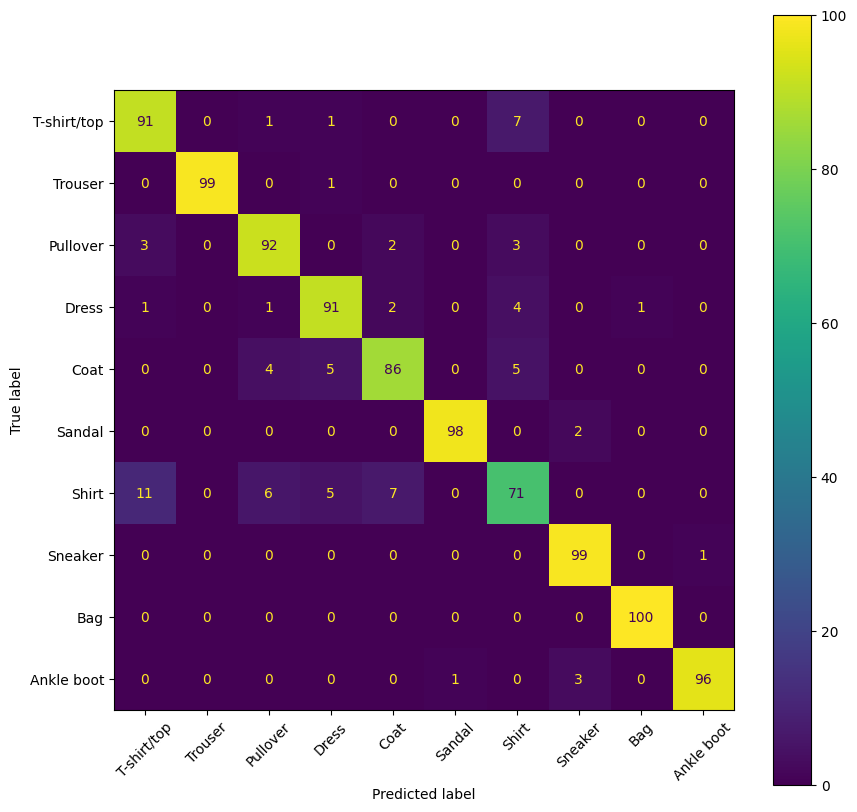

In [ ]:
#모델 성능 평가
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs=trainer.predict(subset_test_dataset)
print(outputs)

y_true=outputs.label_ids
y_pred=outputs.predictions.argmax(1)

labels=list(classes)
matrix=confusion_matrix(y_true, y_pred)
display=ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_,ax=plt.subplots(figsize=(10,10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()

Swin Transformer

In [ ]:
#상대적 위치 편향 계산
import torch

window_size=2 #여러 개의 이미지 패치를 포함하는 격자의 크기
coords_h=torch.arange(window_size)
coords_w=torch.arange(window_size)
coords=torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))
coords_flatten=torch.flatten(coords, 1)
relative_coords=coords_flatten[:,:,None] - coords_flatten[:, None,:]

print(relative_coords)
print(relative_coords.shape)

tensor([[[ 0,  0, -1, -1],
         [ 0,  0, -1, -1],
         [ 1,  1,  0,  0],
         [ 1,  1,  0,  0]],

        [[ 0, -1,  0, -1],
         [ 1,  0,  1,  0],
         [ 0, -1,  0, -1],
         [ 1,  0,  1,  0]]])
torch.Size([2, 4, 4])


In [ ]:
#X, Y축에 대한 위치 행렬
x_coords=relative_coords[0,:,:]
y_coords=relative_coords[1,:,:]

x_coords+=window_size-1
y_coords+=window_size-1
x_coords*=2*window_size-1
print(f"X축에 대한 행렬:\n{x_coords}\n")
print(f"Y축에 대한 행렬:\n{y_coords}\n")

relative_position_index=x_coords+y_coords
print(f"X, Y축에 대한 위치 행렬:\n{relative_position_index}")

X축에 대한 행렬:
tensor([[3, 3, 0, 0],
        [3, 3, 0, 0],
        [6, 6, 3, 3],
        [6, 6, 3, 3]])

Y축에 대한 행렬:
tensor([[1, 0, 1, 0],
        [2, 1, 2, 1],
        [1, 0, 1, 0],
        [2, 1, 2, 1]])

X, Y축에 대한 위치 행렬:
tensor([[4, 3, 1, 0],
        [5, 4, 2, 1],
        [7, 6, 4, 3],
        [8, 7, 5, 4]])


In [ ]:
#X, Y축에 대한 상대적 위치 좌표 변환
num_heads=1
relative_position_bias_table=torch.Tensor(
    torch.zeros((2*window_size-1)*(2*window_size-1), num_heads)
)

relative_position_bias=relative_position_bias_table[relative_position_index.view(-1)]
relative_position_bias=relative_position_bias.view(
    window_size*window_size, window_size*window_size, -1
)
print(relative_position_bias.shape)

torch.Size([4, 4, 1])


In [ ]:
#사전 학습된 스윈 트랜스포머 모델
from transformers import SwinForImageClassification

model=SwinForImageClassification.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
    num_labels=len(train_dataset.classes),
    id2label={idx: label for label, idx in train_dataset.class_to_idx.items()},
    label2id=train_dataset.class_to_idx,
    ignore_mismatched_sizes=True
)

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("L", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("| L", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                if sssub_name=="projection":
                    print("| | L", sssub_name, sssub_module)
                else:
                    print("| | L", sssub_name)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


swin
L embeddings
| L patch_embeddings
| | L projection Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
| L norm
| L dropout
L encoder
| L layers
| | L 0
| | L 1
| | L 2
| | L 3
L layernorm
L pooler
classifier


In [ ]:
#패치 임베딩 모듈
batch=next(iter(train_dataloader))
print("이미지 차원:", batch["pixel_values"].shape)

patch_emb_output, shape=model.swin.embeddings.patch_embeddings(batch["pixel_values"])
print("모듈:", model.swin.embeddings.patch_embeddings)
print("패치 임베딩 차원:", patch_emb_output.shape)

이미지 차원: torch.Size([32, 3, 224, 224])
모듈: SwinPatchEmbeddings(
  (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
)
패치 임베딩 차원: torch.Size([32, 3136, 96])


In [ ]:
#스윈 트랜스포머 블록
for main_name, main_module in model.swin.encoder.layers[0].named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("L", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("| L", ssub_name)

blocks
L 0
| L layernorm_before
| L attention
| L drop_path
| L layernorm_after
| L intermediate
| L output
L 1
| L layernorm_before
| L attention
| L drop_path
| L layernorm_after
| L intermediate
| L output
downsample
L reduction
L norm


In [ ]:
#SwinLayer 구조
print(model.swin.encoder.layers[0].blocks[0])

SwinLayer(
  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (attention): SwinAttention(
    (self): SwinSelfAttention(
      (query): Linear(in_features=96, out_features=96, bias=True)
      (key): Linear(in_features=96, out_features=96, bias=True)
      (value): Linear(in_features=96, out_features=96, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): SwinSelfOutput(
      (dense): Linear(in_features=96, out_features=96, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (drop_path): Identity()
  (layernorm_after): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (intermediate): SwinIntermediate(
    (dense): Linear(in_features=96, out_features=384, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): SwinOutput(
    (dense): Linear(in_features=384, out_features=96, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)


In [ ]:
#W-MSA, SW-MSA 모듈
print("패치 임베딩 차원:", patch_emb_output.shape)

W_MSA=model.swin.encoder.layers[0].blocks[0]
SW_MSA=model.swin.encoder.layers[0].blocks[1]

W_MSA_output=W_MSA(patch_emb_output, W_MSA.input_resolution)[0]
SW_MSA_output=SW_MSA(W_MSA_output, SW_MSA.input_resolution)[0]

print("W-MSA 결과 차원:", W_MSA_output.shape)
print("SW-MSA 결과 차원:", SW_MSA_output.shape)

패치 임베딩 차원: torch.Size([32, 3136, 96])
W-MSA 결과 차원: torch.Size([32, 3136, 96])
SW-MSA 결과 차원: torch.Size([32, 3136, 96])


In [ ]:
#패치 병합
patch_merge=model.swin.encoder.layers[0].downsample
print("patch_merge 모듈: ", patch_merge)

output=patch_merge(SW_MSA_output, patch_merge.input_resolution)
print("patch_merge 결과 차원: ", output.shape)

patch_merge 모듈:  SwinPatchMerging(
  (reduction): Linear(in_features=384, out_features=192, bias=False)
  (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)
patch_merge 결과 차원:  torch.Size([32, 784, 192])


In [ ]:
#스윈 트랜스포머 모델 학습
from transformers import SwinForImageClassification

def subset_sampler(dataset, classes, max_len):
    target_idx=defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices=list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)

def model_init(classses, class_to_idx):
    model=SwinForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model

def collator(data, transform):
    images, labels=zip(*data)
    pixel_values=torch.stack([transform(image) for image in images])
    labels=torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    metric=evaluate.load("f1")
    predictions, labels=eval_pred
    predictions=np.argmax(predictions, axis=1)
    macro_f1=metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

train_dataset=datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset=datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes=train_dataset.classes
class_to_idx=train_dataset.class_to_idx

subset_train_dataset=subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset=subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor=AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224"
)

transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x,x,x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args=TrainingArguments(
    output_dir="../models/Swin-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7,
    report_to="none",
)

trainer=Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor, #토큰을 임베딩해 모델 입력으로 사용하도록 토큰 분리 작업 수행
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
<ipython-input-21-190d0f3b083a>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream

Epoch,Training Loss,Validation Loss,F1
1,0.343200,0.298784,0.893665
2,0.251800,0.256661,0.910309
3,0.219600,0.226514,0.927342


TrainOutput(global_step=1875, training_loss=0.36688949686686195, metrics={'train_runtime': 457.6888, 'train_samples_per_second': 65.547, 'train_steps_per_second': 4.097, 'total_flos': 7.4584635826176e+17, 'train_loss': 0.36688949686686195, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 8.351474  , -3.2172523 , -0.05911191, ..., -2.323432  ,
        -1.3533959 , -2.3914416 ],
       [ 4.939058  ,  0.3982222 ,  0.6705974 , ..., -1.866554  ,
        -1.0704979 , -2.7358372 ],
       [ 7.6013117 , -3.2779975 , -0.59651124, ..., -1.5319761 ,
         0.4687624 , -1.5569323 ],
       ...,
       [-1.3853089 , -3.1105247 , -2.0654986 , ...,  1.3729727 ,
         0.8653836 ,  4.110228  ],
       [-0.49912333, -3.1515996 , -1.5981284 , ...,  1.6285253 ,
        -2.8396726 ,  8.904076  ],
       [-1.6774338 , -2.0116124 , -1.4964681 , ..., -1.168314  ,
        -1.7760957 ,  8.1356735 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

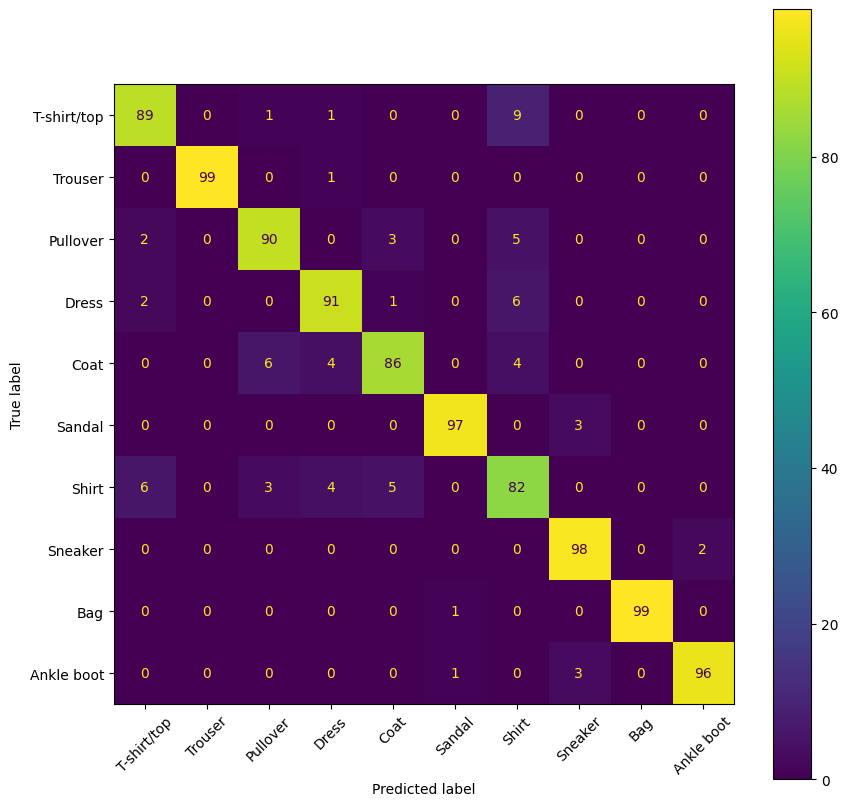

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs=trainer.predict(subset_test_dataset)
print(outputs)

y_true=outputs.label_ids
y_pred=outputs.predictions.argmax(1)

labels=list(classes)
matrix=confusion_matrix(y_true, y_pred)
display=ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_,ax=plt.subplots(figsize=(10,10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()

CvT

In [ ]:
#CvT 모델 이미지 데이터 전처리
from transformers import AutoImageProcessor

image_processor=AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["shortest_edge"],
                image_processor.size["shortest_edge"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x,x,x], 0)
        ),
        transforms.Normalize( #정규화
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

print(f"size: {image_processor.size}")
print(f"mean: {image_processor.image_mean}")
print(f"std: {image_processor.image_std}")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

size: {'shortest_edge': 224}
mean: [0.485, 0.456, 0.406]
std: [0.229, 0.224, 0.225]


In [ ]:
#사전 학습된 CvT 모델
from transformers import CvtForImageClassification

model=CvtForImageClassification.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21",
    num_labels=len(train_dataset.classes),
    id2label={idx: label for label, idx in train_dataset.class_to_idx.items()},
    label2id=train_dataset.class_to_idx,
    ignore_mismatched_sizes=True
)

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("L", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print(" L", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("  L", sssub_name)

config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/127M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cvt
L encoder
 L stages
  L 0
  L 1
  L 2
layernorm
classifier


In [ ]:
#CvT 모델의 스테이지 구조
stages=model.cvt.encoder.stages
print(stages[0])

CvtStage(
  (embedding): CvtEmbeddings(
    (convolution_embeddings): CvtConvEmbeddings(
      (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
      (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layers): Sequential(
    (0): CvtLayer(
      (attention): CvtAttention(
        (attention): CvtSelfAttention(
          (convolution_projection_query): CvtSelfAttentionProjection(
            (convolution_projection): CvtSelfAttentionConvProjection(
              (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (linear_projection): CvtSelfAttentionLinearProjection()
          )
          (convolution_projection_key): CvtSelfAttentionProjection(
            (convolution_projection): CvtSelfAtte

In [ ]:
#셀프 어텐션 적용
batch=next(iter(train_dataloader))
print("이미지 차원:", batch["pixel_values"].shape)
patch_emb_output=stages[0].embedding(batch["pixel_values"])
print("패치 임베딩 차원:", patch_emb_output.shape)

batch_size, num_channels, height, width=patch_emb_output.shape
hidden_state=patch_emb_output.view(batch_size, num_channels, height*width).permute(0, 2, 1)
print("셀프 어텐션 입력 차원:", hidden_state.shape)

attention_output=stages[0].layers[0].attention.attention(hidden_state, height, width)
print("셀프 어텐션 출력 차원:", attention_output.shape)

이미지 차원: torch.Size([32, 3, 224, 224])
패치 임베딩 차원: torch.Size([32, 64, 56, 56])
셀프 어텐션 입력 차원: torch.Size([32, 3136, 64])
셀프 어텐션 출력 차원: torch.Size([32, 3136, 64])


In [ ]:
#CvT 모델 학습
from transformers import CvtForImageClassification

def subset_sampler(dataset, classes, max_len):
    target_idx=defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices=list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)

def model_init(classses, class_to_idx):
    model=CvtForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/cvt-21",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model

def collator(data, transform):
    images, labels=zip(*data)
    pixel_values=torch.stack([transform(image) for image in images])
    labels=torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    metric=evaluate.load("f1")
    predictions, labels=eval_pred
    predictions=np.argmax(predictions, axis=1)
    macro_f1=metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

train_dataset=datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset=datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes=train_dataset.classes
class_to_idx=train_dataset.class_to_idx

subset_train_dataset=subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset=subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor=AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["shortest_edge"],
                image_processor.size["shortest_edge"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x,x,x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args=TrainingArguments(
    output_dir="../models/CvT-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7,
    report_to="none",
)

trainer=Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor, #토큰을 임베딩해 모델 입력으로 사용하도록 토큰 분리 작업 수행
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
<ipython-input-27-627846fcf2d7>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-2

Epoch,Training Loss,Validation Loss,F1
1,0.809900,0.343038,0.875449
2,0.683800,0.279881,0.911356
3,0.675900,0.266789,0.907647


TrainOutput(global_step=1875, training_loss=0.7911553263346354, metrics={'train_runtime': 696.9885, 'train_samples_per_second': 43.042, 'train_steps_per_second': 2.69, 'total_flos': 8.4649093853184e+17, 'train_loss': 0.7911553263346354, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 6.4969053 , -1.2999011 , -0.2894074 , ..., -1.553357  ,
        -0.56032777, -1.5990337 ],
       [ 3.4476542 ,  0.05806433, -1.5227815 , ..., -1.8336595 ,
        -1.5038162 , -2.6078615 ],
       [ 6.8501706 , -1.3141633 , -0.03161642, ..., -1.1987059 ,
        -1.0130116 , -1.6952494 ],
       ...,
       [-0.85330296, -1.4147227 , -0.7595378 , ...,  1.2993029 ,
        -0.1488606 ,  4.4355645 ],
       [-0.94538265, -0.60303545, -0.40883625, ...,  0.5241105 ,
        -1.0194108 ,  6.8774824 ],
       [-1.7446471 ,  0.06367205, -0.7284905 , ..., -0.43068853,
        -0.75806016,  6.6345167 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

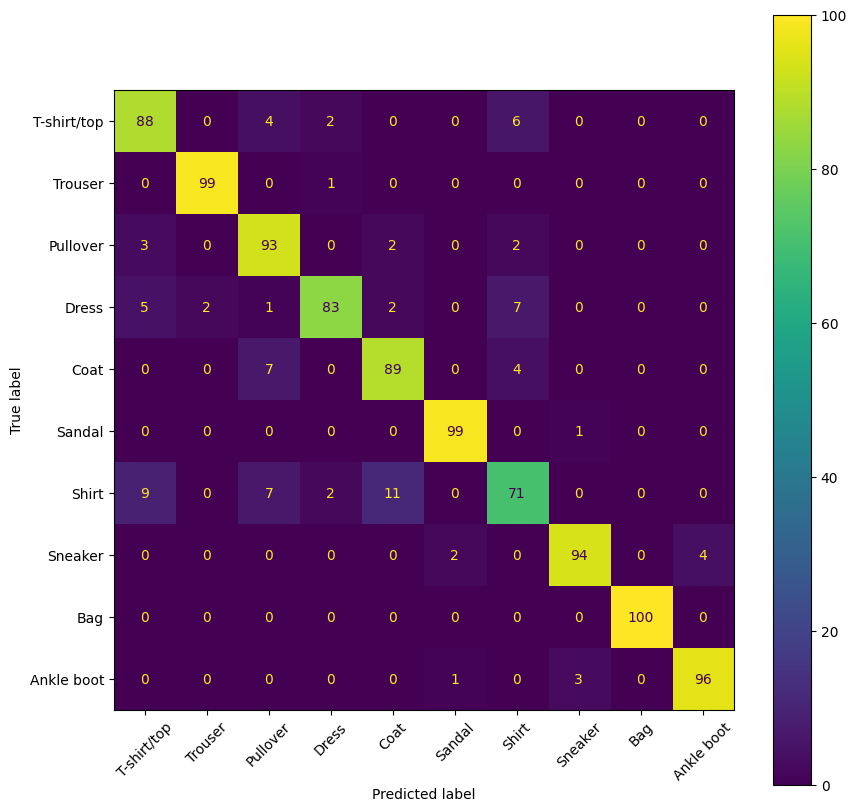

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs=trainer.predict(subset_test_dataset)
print(outputs)

y_true=outputs.label_ids
y_pred=outputs.predictions.argmax(1)

labels=list(classes)
matrix=confusion_matrix(y_true, y_pred)
display=ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_,ax=plt.subplots(figsize=(10,10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()